In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import os
import scipy.stats
#import corner
from astropy.io import fits
from astropy.table import Table

plt.style.use('seaborn-whitegrid')

np.random.seed(2) #Número aleatorio para que los procesos se asimilen.

Se comienza con los arreglos generados en la clase pasada:

In [2]:
#Para generar los puntos aleatorios, probemos con un arreglo como el siguiente:
x = np.linspace(0, 2, 15)
a_0, b_0 = 3, 2

#Queremos tender a valores que coincidan con y = 3x + 2, por tanto generamos para cada x una y:
error = np.random.normal(0, 0.2, 15)
y = 3 * x + 2 + error

In [3]:
#Y la función de la recta:
def recta(x, a, b):
    return a * x + b

#La función del logaritmo del likelihood:
def chisq(parametros, data):
    x = data[0]
    y = data[1]
    y_err = data[2]
    
    model = recta(x, parametros[0], parametros[1])
    chisq = (y - model) ** 2 / y_err ** 2
    return chisq.sum()

Para el <strong>método de metrópolis</strong> se hace uso de un valor inicial de los parámetros, en esta ocasión se comenzará con <strong>a = 1.5, b = 4.</strong> Se producirá un arreglo en el que se guardarán los valores de <strong>a, b</strong> para los cuales el <strong>likelihood</strong> es mayor que en la iteración anterior o que cumple con la condición de ser menor que un número aleatorio producido en el rango [0, 1].

Además, requiero de comparar la condición de que el <strong>likelihood</strong> sea mayor que en una iteración anterior, por lo que se produce un valor inicial para éste.

In [4]:
N = 10000
caminos = 5 #Que sea j el número de caminos.
sigma = 0.2
a_inicial = []
b_inicial = []
lh_inicial = []

#Valor inicial de parámetros:
for i in range(caminos):
    a_inicial.append(np.random.normal(3, sigma))
    b_inicial.append(np.random.normal(2, sigma))
    #Valor inicial del likelihood:
    lh_inicial.append(chisq([a_inicial[i], b_inicial[i]], [x, y, error]))

#Arreglos donde se guardarán los valores de a, b, likelihood:
#a = [range(N) for i in range(caminos)]
a = []
b = []
lh = []

#Se guardan los primeros valores propuestos:
for i in range(caminos):
    a.append([a_inicial[i]])
    b.append([b_inicial[i]])
    lh.append([lh_inicial[i]])

Ahora que se tienen los valores iniciales y el lugar donde se guardará el valor de los parámetros obtenidos, es momento de producir el <strong>método de metrópolis</strong>:

<strong>Nota:</strong> para ésto, se producirán N intentos de <strong>a, b</strong> por pares.

In [5]:
k = 0

for j in range(caminos):
    for i in range(N):
        a_aux = np.random.normal(a[j][k], sigma)#Se generan dos valores random, no importa la distribución en rango [0,10].
        b_aux = np.random.normal(b[j][k], sigma)
        lh_aux = chisq([a_aux, b_aux], [x, y, error]) #Primer comparación para actualización de likelihood.
        if lh_aux < lh_inicial[j]: #La maximización del likelihood equivale a la minimización de chi square.
            #Si se cumple la condición, se agregan a, b y se actualiza el valor del likelihood.
            a[j].append(a_aux)
            b[j].append(b_aux)
            lh[j].append(lh_aux)
            lh_inicial[j] = lh_aux
            k += 1
        else:
            comparador = np.random.uniform(0, 1)
            if (lh_aux - lh_inicial[j]) < comparador:
                a[j].append(a_aux)
                b[j].append(b_aux)
                lh[j].append(lh_aux)
                lh_inicial[j] = lh_aux #En esta parte tengo duda, se acepta el valor, pero... ¿se actualiza lh?
                k += 1
            else:
                continue
    k = 0

In [6]:
#El mínimo chi square está en:
parametros = []
for i in range(caminos):
    parametros.append(np.where(lh[i] == np.min(lh[i])))
parametros

[(array([8]),), (array([11]),), (array([15]),), (array([7]),), (array([9]),)]

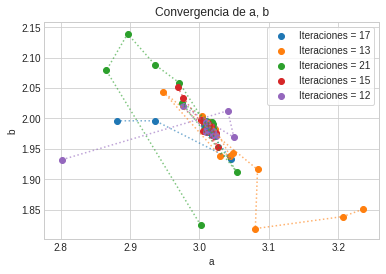

In [7]:
plt.title('Convergencia de a, b')
for i in range(caminos):
    plt.scatter(a[i], b[i], label = 'Iteraciones = {0}'.format(len(a[i])))
    plt.plot(a[i], b[i], linestyle = ':', alpha = 0.6)
    plt.ylabel('b')
    plt.xlabel('a')
    plt.legend(frameon = True)
plt.show()

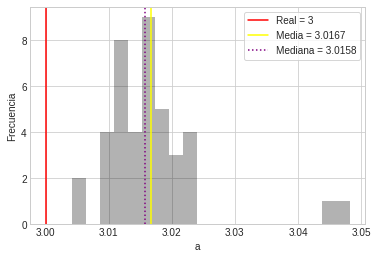

In [8]:
a_total = []

for i in range(caminos):
    for j in range(np.int(len(a[i]) / 2), len(a[i])):
        a_total.append(a[i][j])
plt.hist(a_total, 20, color = 'black', alpha = 0.3)
plt.axvline(a_0, color = 'red', label = 'Real = {0}'.format(a_0))
plt.axvline(np.mean(a_total), color = 'yellow', label = 'Media = {0}'.format(np.round(np.mean(a_total), 4)))
plt.axvline(np.median(a_total), color = 'purple', linestyle = ':', label = 'Mediana = {0}'.format(np.round(np.median(a_total), 4)))
plt.xlabel('a')
plt.ylabel('Frecuencia')
plt.legend(frameon = True)
plt.show()

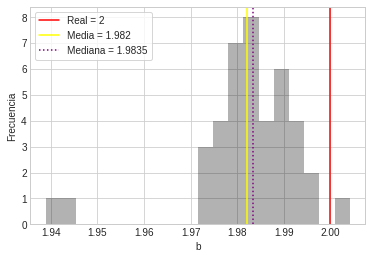

In [9]:
b_total = []

for i in range(caminos):
    for j in range(np.int(len(b[i]) / 2), len(b[i])):
        b_total.append(b[i][j])
plt.hist(b_total, 20, color = 'black', alpha = 0.3)
plt.axvline(b_0, color = 'red', label = 'Real = {0}'.format(b_0))
plt.axvline(np.mean(b_total), color = 'yellow', label = 'Media = {0}'.format(np.round(np.mean(b_total), 4)))
plt.axvline(np.median(b_total), color = 'purple', linestyle = ':', label = 'Mediana = {0}'.format(np.round(np.median(b_total), 4)))
plt.xlabel('b')
plt.ylabel('Frecuencia')
plt.legend(frameon = True)
plt.show()

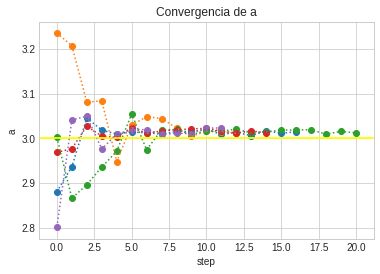

In [10]:
longitud = []
for i in range(caminos):
    longitud.append([])
    for j in range(len(a[i])):
        longitud[i].append(j)

for i in range(caminos):
    plt.scatter(longitud[i], a[i], label = 'Iteraciones = {0}'.format(len(a[i])))
    plt.plot(longitud[i], a[i], linestyle = ':')
    plt.axhline(a_0, color = 'yellow', alpha = 0.5)
plt.xlabel('step')
plt.ylabel('a')
plt.title('Convergencia de a')
plt.show()

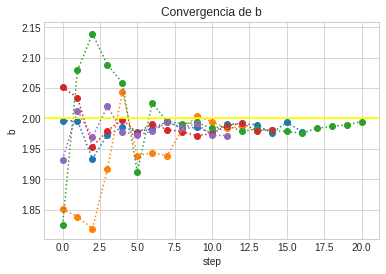

In [11]:
for i in range(caminos):
    plt.scatter(longitud[i], b[i], label = 'Iteraciones = {0}'.format(len(a[i])))
    plt.plot(longitud[i], b[i], linestyle = ':')
    plt.axhline(b_0, color = 'yellow', alpha = 0.5)
plt.xlabel('step')
plt.ylabel('b')
plt.title('Convergencia de b')
plt.show()

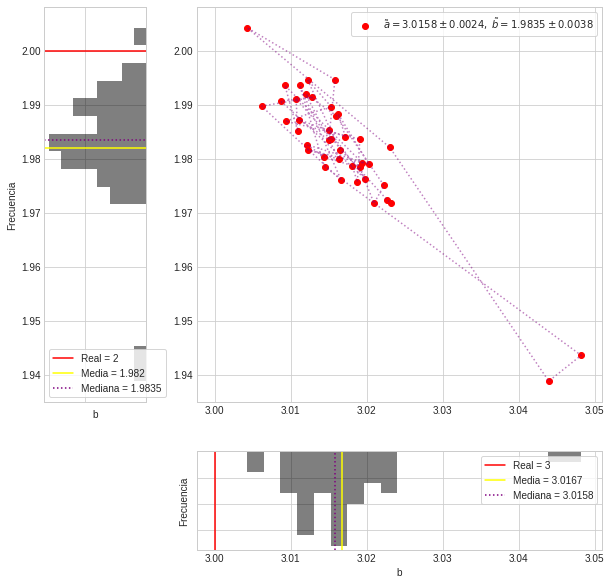

In [14]:
fig = plt.figure(figsize=(10, 10))
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.5)
#Gráfica central
main_ax = fig.add_subplot(grid[:-1, 1:])
b_hist = fig.add_subplot(grid[:-1, 0], xticklabels = [], sharey = main_ax)
a_hist = fig.add_subplot(grid[-1, 1:], yticklabels = [], sharex = main_ax)
main_ax.plot(a_total, b_total, markersize = 10, linestyle = ':', color = 'purple', alpha = 0.5)
main_ax.scatter(a_total, b_total, color = 'red', label = '$\~a = {} \pm {},$ $\~b = {} \pm {}$'.format(np.round(np.median(a_total), 4), np.round(np.abs(np.median(a_total) - np.percentile(a_total, 68)), 4), np.round(np.median(b_total), 4), np.round(np.abs(np.median(b_total) - np.percentile(b_total, 68)), 4)))
main_ax.legend(frameon = True)

#Gráfica que comparte el eje x con la central:
a_hist.hist(a_total, 20, histtype='stepfilled',orientation='vertical', color = 'black', alpha = 0.5)
a_hist.axvline(a_0, color = 'red', label = 'Real = {0}'.format(a_0))
a_hist.axvline(np.mean(a_total), color = 'yellow', label = 'Media = {0}'.format(np.round(np.mean(a_total), 4)))
a_hist.axvline(np.median(a_total), color = 'purple', linestyle = ':', label = 'Mediana = {0}'.format(np.round(np.median(a_total), 4)))
a_hist.set_xlabel('b')
a_hist.set_ylabel('Frecuencia')
a_hist.legend(frameon = True, loc = 'best')
a_hist.invert_yaxis()

#Gráfica que comparte el eje y con la central:
b_hist.hist(b_total, 20, histtype='stepfilled',orientation='horizontal', color = 'black', alpha = 0.5)
b_hist.axhline(b_0, color = 'red', label = 'Real = {0}'.format(b_0))
b_hist.axhline(np.mean(b_total), color = 'yellow', label = 'Media = {0}'.format(np.round(np.mean(b_total), 4)))
b_hist.axhline(np.median(b_total), color = 'purple', linestyle = ':', label = 'Mediana = {0}'.format(np.round(np.median(b_total), 4)))
b_hist.set_xlabel('b')
b_hist.set_ylabel('Frecuencia')
b_hist.legend(frameon = True, loc = 'best')
b_hist.invert_xaxis()

In [15]:
np.percentile(a_total, 68)

3.0181940321327927

### <strong>Posterior</strong>

Para este análisis, se considera que el <strong>prior</strong> tiene una distribución normal, además se sabe que el <strong>posterior</strong> es proporcional al producto del <strong>prior, likelihood,</strong> por lo que se procederá con el mismo método, únicamente modificando la operación de asignación y comparación.

Al no cumplirse la condición principal, se procederá con comparar con un <strong>número con distribución uniforme,</strong> tal como se especificó en clase.

In [50]:
k = 0
media_a, media_b, sigma = 3.0, 2.0, 0.2

#Nota. Requiero del peso de probabilidad prior, para determinar la probabilidad de un valor, se hace uso de scipy.
post_inicial = []
def prior(a):
    return scipy.stats.norm.pdf(a, media_a, sigma)

for i in range(caminos):
    post_inicial.append(lh_inicial[i] * prior(a_inicial[i]) * prior(b_inicial[i]))

#Ésto debería ser posterior
posterior = []
for i in range(caminos):
    posterior.append([post_inicial[i]])

In [51]:
k = 0

for j in range(caminos):
    for i in range(N):
        a_aux = np.random.normal(a[j][k], sigma) #Se generan dos valores random, no importa la distribución en rango [0,10].
        b_aux = np.random.normal(b[j][k], sigma)
        lh_aux = chisq([a_aux, b_aux], [x, y, error]) #Primer comparación para actualización de likelihood.
        post_aux = lh_aux * prior(a_aux) * prior(b_aux)
        if post_aux < post_inicial[j]: #La maximización del likelihood equivale a la minimización de chi square.
            #Si se cumple la condición, se agregan a, b y se actualiza el valor del likelihood.
            a[j].append(a_aux)
            b[j].append(b_aux)
            posterior[j].append(post_aux)
            post_inicial[j] = post_aux
            k += 1
        else:
            comparador = np.log(np.random.uniform(0, 1)) #Correción del logaritmo.
            if (post_aux - post_inicial[j]) < comparador:
                a[j].append(a_aux)
                b[j].append(b_aux)
                posterior[j].append(post_aux)
                post_inicial[j] = post_aux #En esta parte tengo duda, se acepta el valor, pero... ¿se actualiza lh?
                k += 1
            else:
                continue
    k = 0

In [52]:
#El mínimo chi square está en:
parametros = []
for i in range(caminos):
    parametros.append(np.where(posterior[i] == np.min(posterior[i])))
parametros

[(array([9]),), (array([8]),), (array([2]),), (array([11]),), (array([6]),)]

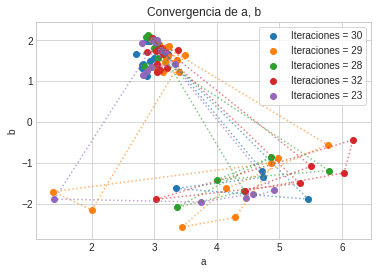

In [53]:
plt.title('Convergencia de a, b')
for i in range(caminos):
    plt.scatter(a[i], b[i], label = 'Iteraciones = {0}'.format(len(a[i])))
    plt.plot(a[i], b[i], linestyle = ':', alpha = 0.6)
    plt.ylabel('b')
    plt.xlabel('a')
    plt.legend(frameon = True)
plt.show()

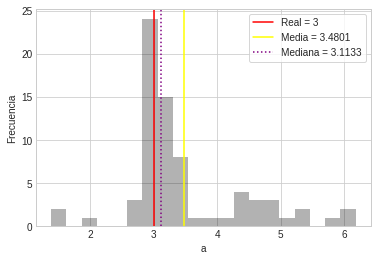

In [54]:
a_total = []

for i in range(caminos):
    for j in range(np.int(len(a[i]) / 2), len(a[i])):
        a_total.append(a[i][j])
plt.hist(a_total, 20, color = 'black', alpha = 0.3)
plt.axvline(a_0, color = 'red', label = 'Real = {0}'.format(a_0))
plt.axvline(np.mean(a_total), color = 'yellow', label = 'Media = {0}'.format(np.round(np.mean(a_total), 4)))
plt.axvline(np.median(a_total), color = 'purple', linestyle = ':', label = 'Mediana = {0}'.format(np.round(np.median(a_total), 4)))
plt.xlabel('a')
plt.ylabel('Frecuencia')
plt.legend(frameon = True)
plt.show()

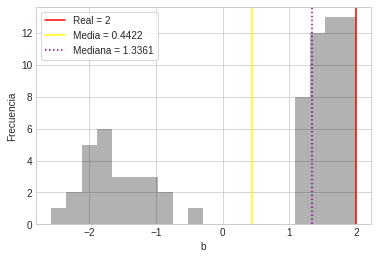

In [55]:
b_total = []

for i in range(caminos):
    for j in range(np.int(len(b[i]) / 2), len(b[i])):
        b_total.append(b[i][j])
plt.hist(b_total, 20, color = 'black', alpha = 0.3)
plt.axvline(b_0, color = 'red', label = 'Real = {0}'.format(b_0))
plt.axvline(np.mean(b_total), color = 'yellow', label = 'Media = {0}'.format(np.round(np.mean(b_total), 4)))
plt.axvline(np.median(b_total), color = 'purple', linestyle = ':', label = 'Mediana = {0}'.format(np.round(np.median(b_total), 4)))
plt.xlabel('b')
plt.ylabel('Frecuencia')
plt.legend(frameon = True)
plt.show()

## <strong>Referencias</strong>

[1] Dr. Veselina Kalinova. Lecture notes on Regression: MarkovChain Monte Carlo (MCMC). Max Planck Institute for Radioastronomy, Bonn “Machine Learning course: the elegant way to extractinformation from data”, 13-23 Ferbruary, 2017. url: https://events.mpifr-bonn.mpg.de/indico/event/30/material/slides/12.pdf

[2] Maximum Likelihood Estimation For Regression. Ashan Priyadarshana. url: https://medium.com/quick-code/maximum-likelihood-estimation-for-regression-65f9c99f815d

[3] Markov Chain Monte Carlo. url: https://rein.utsc.utoronto.ca/teaching/PSCB57_notes_lecture11.pdf